# Ejercicio 3 — Clasificación de imágenes (ardilla, caballo, vaca)

En este ejercicio construimos un clasificador de imágenes con **CNN** para tres clases (*ardilla, caballo, vaca*). Entrenaremos **3 modelos con la misma arquitectura** (3 conv + 3 pool + flatten + dropout + densa + salida) cambiando **solo el optimizador**. Después compararemos métricas, evaluaremos en **test** (matriz de confusión) y mostraremos **5 imágenes** aleatorias con su predicción.

## Índice de pasos
1. Preparación del entorno e importaciones  
2. Rutas y estructura mínima del ejercicio (con README)  
3. Dataset: descarga/colocación y verificación (`animales/train|val|test`)  
4. Carga de datos y *data pipeline* (tamaño, *batch*, *augmentation*)  
5. Arquitectura base de la CNN (3×[Conv2D+Pool] + Flatten + Dropout + Dense + Softmax)  
6. Modelo A (Optimizador 1) — entrenamiento  
7. Modelo B (Optimizador 2) — entrenamiento  
8. Modelo C (Optimizador 3) — entrenamiento  
9. Tabla comparativa (loss/accuracy Train vs Val)  
10. Evaluación en **test** y matriz de confusión  
11. Visualización de 5 imágenes aleatorias con predicción  
12. Conclusiones

## 1.Preparación del entorno e importaciones

Cargamos las librerías que usaremos:
- **tensorflow/keras**: definición y entrenamiento de las CNN, y carga de datos por lotes.
- **numpy/pandas**: manipulación de datos y tabla comparativa de métricas.
- **matplotlib**: gráficos (curvas de entrenamiento y matriz de confusión).
- **sklearn.metrics**: `confusion_matrix` y métricas auxiliares.
- **pathlib/os**: gestión de rutas y creación de la estructura de carpetas.

> **Modo de ejecución para la entrega:** trabajamos con dos banderas muy simples.
> - `RUN_TRAINING = False` → no reentrenamos; **cargamos** modelos e historiales guardados.
> - `RECALC_TEST = False` → no reevaluamos; **leemos** métricas de test y la matriz de confusión ya generadas.

In [ ]:
# Importaciones
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, Sequential
from sklearn.metrics import confusion_matrix, classification_report

# Reproducibilidad básica
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

In [ ]:
# === Modo entrega (Ejercicio 3) ===
RUN_TRAINING = False   # Entrega: no reentrena; solo carga artefactos guardados
RECALC_TEST  = False   # Entrega: no reevalúa test; lee métricas/CM ya guardadas

## 2.Rutas y estructura mínima del ejercicio (con README)

Hemos trabajado montando **Google Drive**, pero dejamos el cuaderno **preparado para entrega portable** con rutas relativas. La estructura es:

- `notebooks/` — cuaderno(s) del ejercicio  
- `src/` — utilidades (si hiciera falta)  
- `scripts/` — script `.py` exportado del notebook  
- `data/animales/` — carpeta **animales** con `train/`, `validation/`, `test`  
- `outputs/models/` — modelos `.keras`  
- `outputs/figures/` — curvas y matriz de confusión  
- `outputs/csv/` — histories y tabla comparativa  
- `outputs/docs/` — informe en **PDF** del notebook

En el README indicamos que el **dataset no se incluye en el ZIP** y que debe copiarse en `data/animales/` antes de ejecutar.

In [ ]:
# === Rutas y estructura (trabajo en Drive y entrega portable) ===

USE_DRIVE = False  # False -> (monta Drive)
                   # False -> (Para la ENTREGA)

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT = Path("/content/drive/MyDrive/MASTER BIG DATA/md2_2025")
    EJ3  = ROOT / "ej3_clasificacion_animales"
else:
    here = Path(".").resolve()
    EJ3  = here if (here.name == "ej3_clasificacion_animales") else (here / "ej3_clasificacion_animales")

PATHS = {
    "root":       str(EJ3.parent),
    "ej3":        str(EJ3),
    "nb":         str(EJ3 / "notebooks"),
    "src":        str(EJ3 / "src"),
    "scripts":    str(EJ3 / "scripts"),
    "data":       str(EJ3 / "data" / "animales"),
    "out_models": str(EJ3 / "outputs" / "models"),
    "out_figs":   str(EJ3 / "outputs" / "figures"),
    "out_csv":    str(EJ3 / "outputs" / "csv"),
    "out_docs":   str(EJ3 / "outputs" / "docs"),
}

def ensure_dir(p: str):
    Path(p).mkdir(parents=True, exist_ok=True)

# crea solo las carpetas que necesitamos
for k in ("nb","src","scripts","data","out_models","out_figs","out_csv","out_docs"):
    ensure_dir(PATHS[k])

# README
readme = Path(PATHS["ej3"]) / "README.md"
readme.write_text("""# Ejercicio 3 — Clasificación de imágenes (ardilla, caballo, vaca)

**Objetivo.** Entrenamos 3 CNN con la misma arquitectura cambiando solo el optimizador (Adam, SGD, RMSprop), comparamos métricas y evaluamos en test (matriz de confusión + 5 predicciones).

## Datos (no incluidos en el ZIP)
Colocar la carpeta `animales/` en `data/animales/` con:
- `train/{ardilla,caballo,vaca}`
- `validation/{ardilla,caballo,vaca}`
- `test/{ardilla,caballo,vaca}`

## Salidas
- `outputs/models/`  → modelos `.keras`
- `outputs/csv/`     → histories y comparativa
- `outputs/figures/` → curvas, matriz, muestras

## Modo entrega
- En el notebook: `RUN_TRAINING = False` y `RECALC_TEST = False` para cargar artefactos ya guardados.
""", encoding="utf-8")

print("README:", readme)
print("Rutas clave:")
for k in ("nb","scripts","data","out_models","out_figs","out_csv","out_docs"):
    print(f"  {k:>10} → {PATHS[k]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
README: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/README.md
Rutas clave:
          nb → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/notebooks
     scripts → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/scripts
        data → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/data/animales
  out_models → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/outputs/models
    out_figs → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/outputs/figures
     out_csv → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/outputs/csv
    out_docs → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/outputs/docs


## 3.Dataset listo: resumen y validación de conteos

Verificamos las **cantidades esperadas** por *split* y clase:
- **train:** 1200 por clase  
- **validation:** 100 por clase  
- **test:** 100 por clase

Guardamos además el orden de clases que usaremos en todo el cuaderno.

In [ ]:
data_dir = Path(PATHS["data"])  # .../ej3_clasificacion_animales/data/animales
splits_expected = {"train": 1200, "validation": 100, "test": 100}
classes = ["ardilla", "caballo", "vaca"]
exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}

rows = []
for sp, exp_per_class in splits_expected.items():
    for cl in classes:
        folder = data_dir / sp / cl
        if not folder.exists():
            raise FileNotFoundError(f"Falta carpeta: {folder}")
        n = sum(1 for p in folder.iterdir() if p.suffix.lower() in exts)
        rows.append({
            "split": sp,
            "clase": cl,
            "n_imagenes": n,
            "esperado": exp_per_class,
            "ok": (n == exp_per_class)
        })

df_counts = pd.DataFrame(rows)
print(df_counts.to_string(index=False))

print("\nTotal por split:")
print(df_counts.groupby("split")["n_imagenes"].sum().to_string())

if not df_counts["ok"].all():
    raise ValueError("Hay diferencias con los conteos esperados. Revisa las filas 'ok=False' arriba.")

# Orden de clases fijo para todo el ejercicio
CLASS_NAMES = classes
NUM_CLASSES = len(CLASS_NAMES)
print("\nClases:", CLASS_NAMES, "| NUM_CLASSES:", NUM_CLASSES)

     split   clase  n_imagenes  esperado   ok
     train ardilla        1200      1200 True
     train caballo        1200      1200 True
     train    vaca        1200      1200 True
validation ardilla         100       100 True
validation caballo         100       100 True
validation    vaca         100       100 True
      test ardilla         100       100 True
      test caballo         100       100 True
      test    vaca         100       100 True

Total por split:
split
test           300
train         3600
validation     300

Clases: ['ardilla', 'caballo', 'vaca'] | NUM_CLASSES: 3


## 4.Carga de datos y *data pipeline* (tamaño, *batch*, *augmentation*)

Preparamos los *datasets* de **train/validation/test** desde `data/animales/`:
- Redimensionamos a **224×224** y normalizamos a `[0,1]`.
- Usamos *batches* de **32** y aceleramos con `cache()` + `prefetch()`.
- Definimos un bloque de **aumentación** moderada (flip horizontal, rotación y zoom) que aplicaremos **solo en entrenamiento**.

Mantenemos el **orden de clases**: `['ardilla','caballo','vaca']`.

In [ ]:
# Parámetros de entrada
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CLASS_NAMES = ["ardilla", "caballo", "vaca"]

from tensorflow.keras.utils import image_dataset_from_directory

data_dir = Path(PATHS["data"])

# Datasets
train_ds = image_dataset_from_directory(
    data_dir / "train",
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = image_dataset_from_directory(
    data_dir / "validation",
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    data_dir / "test",
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Normalización y aumento (solo se aplicará en entrenamiento)

normalization = layers.Rescaling(1./255)
augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")

# Optimización del pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# Comprobación rápida de formas
batch_images, batch_labels = next(iter(train_ds))
print("Batch imágenes:", batch_images.shape)  # (batch, 224, 224, 3)
print("Batch etiquetas:", batch_labels.shape) # (batch,)
print("Clases:", CLASS_NAMES)

Found 3600 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Batch imágenes: (32, 224, 224, 3)
Batch etiquetas: (32,)
Clases: ['ardilla', 'caballo', 'vaca']


### 4.1 Vista rápida de muestras (entrenamiento)

Mostramos 12 imágenes del primer *batch* con su etiqueta para verificar que la carga es correcta.

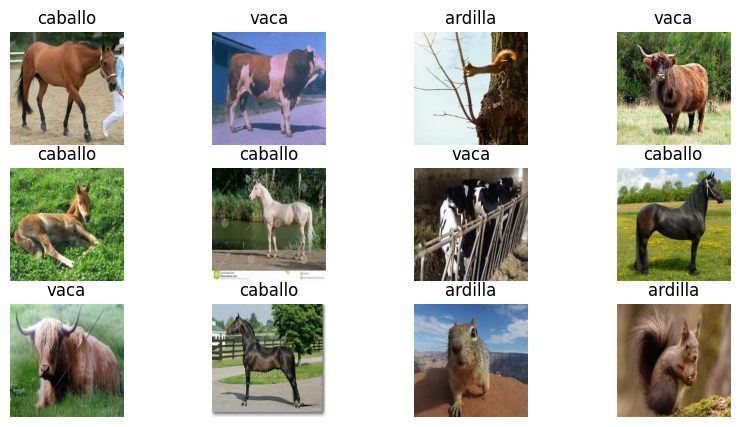

In [ ]:
plt.figure(figsize=(10,5))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    img = batch_images[i].numpy().astype("uint8")
    plt.imshow(img)
    plt.title(CLASS_NAMES[int(batch_labels[i])])
    plt.axis("off")
plt.show()

## 5.Arquitectura base de la CNN

Definimos una **CNN** común para los tres modelos:  
entrada **224×224×3** → **[Conv2D + MaxPool] × 3** → **Flatten** → **Dropout** → **Dense** → **Softmax (3 clases)**.  
Incluimos **data augmentation** y **normalización** al principio del modelo para mantener un *pipeline* limpio y reproducible.

In [ ]:
# Arquitectura base
NUM_CLASSES = len(CLASS_NAMES)

def build_cnn(
    input_shape=(224, 224, 3),
    num_classes=3,
    filters=(32, 64, 128),
    kernel_size=(3, 3),
    pool_size=(2, 2),
    dropout=0.4,
    dense_units=128,
):
    inputs = layers.Input(shape=input_shape)
    x = augmentation(inputs)        # solo en train; en inferencia se desactiva
    x = normalization(x)

    for f in filters:
        x = layers.Conv2D(f, kernel_size, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="cnn_base")
    return model

model_base = build_cnn(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)
model_base.summary()

Model: "cnn_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,819 (49.36 MB)

 Trainable params: 12,938,819 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

## 6.Modelo A — Optimizador: Adam

Entrenamos la CNN base con **Adam** (LR adaptativa por parámetro, momentum+RMSProp) porque suele converger rápido; en los puntos 7 y 8 probaremos **SGD (momentum)** y **RMSprop** dejando el resto igual para comparar en igualdad de condiciones.

Guardamos el mejor checkpoint por **`val_accuracy`** y exportamos el **history** a CSV para la tabla comparativa posterior.

In [ ]:
# Modelo A (Adam)
#solo entrena si RUN_TRAINING=True
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

ckpt_path = Path(PATHS["out_models"]) / "cnn_modelA_adam.keras"
csv_path  = Path(PATHS["out_csv"])    / "history_modelA_adam.csv"
Path(PATHS["out_models"]).mkdir(parents=True, exist_ok=True)
Path(PATHS["out_csv"]).mkdir(parents=True, exist_ok=True)

if RUN_TRAINING:
    model_a = build_cnn(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)
    model_a.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    callbacks = [
        EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
        ModelCheckpoint(filepath=str(ckpt_path), monitor="val_accuracy", save_best_only=True)
    ]
    hist_a = model_a.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks, verbose=1)
    pd.DataFrame(hist_a.history).to_csv(csv_path, index=False)

print("Modelo A (Adam) — modo entrega: no se entrena; se cargarán resultados guardados (modelo + history).")

Modelo A (Adam) — modo entrega: no se entrena; se cargarán resultados guardados (modelo + history).


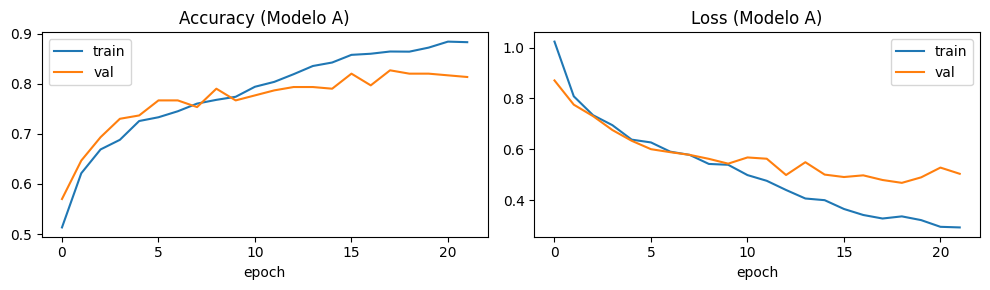

In [ ]:
# Curvas de entrenamiento — Modelo A
csv_a = Path(PATHS["out_csv"]) / "history_modelA_adam.csv"

try:
    # Si acabamos de entrenar en esta sesión, usa hist_a; si no, lee el CSV guardado
    dfA = pd.DataFrame(hist_a.history) if (RUN_TRAINING and 'hist_a' in globals()) else pd.read_csv(csv_a)
except FileNotFoundError:
    print("No encuentro el history de A:", csv_a, "\nEjecuta RUN_TRAINING=True una vez para generarlo.")
else:
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(dfA["accuracy"], label="train")
    ax[0].plot(dfA["val_accuracy"], label="val")
    ax[0].set_title("Accuracy (Modelo A)"); ax[0].set_xlabel("epoch"); ax[0].legend()

    ax[1].plot(dfA["loss"], label="train")
    ax[1].plot(dfA["val_loss"], label="val")
    ax[1].set_title("Loss (Modelo A)"); ax[1].set_xlabel("epoch"); ax[1].legend()

    plt.tight_layout(); plt.show()

## 7.Modelo B — Optimizador: SGD (momentum)

Probamos **SGD** con `momentum=0.9` y `nesterov=True`. Dejamos la misma arquitectura, pérdida, métricas, *batch* y número de épocas para comparar en igualdad de condiciones.

In [ ]:
# Modelo B (SGD + momentum)
#solo entrena si RUN_TRAINING=True
ckpt_path = Path(PATHS["out_models"]) / "cnn_modelB_sgd.keras"
csv_path  = Path(PATHS["out_csv"])    / "history_modelB_sgd.csv"
Path(PATHS["out_models"]).mkdir(parents=True, exist_ok=True)
Path(PATHS["out_csv"]).mkdir(parents=True, exist_ok=True)

if RUN_TRAINING:
    model_b = build_cnn(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)
    model_b.compile(
        optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    callbacks = [
        EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
        ModelCheckpoint(filepath=str(ckpt_path), monitor="val_accuracy", save_best_only=True)
    ]
    hist_b = model_b.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks, verbose=1)
    pd.DataFrame(hist_b.history).to_csv(csv_path, index=False)

print("Modelo B (SGD) — modo entrega: no se entrena; se cargarán resultados guardados (modelo + history).")

Modelo B (SGD) — modo entrega: no se entrena; se cargarán resultados guardados (modelo + history).


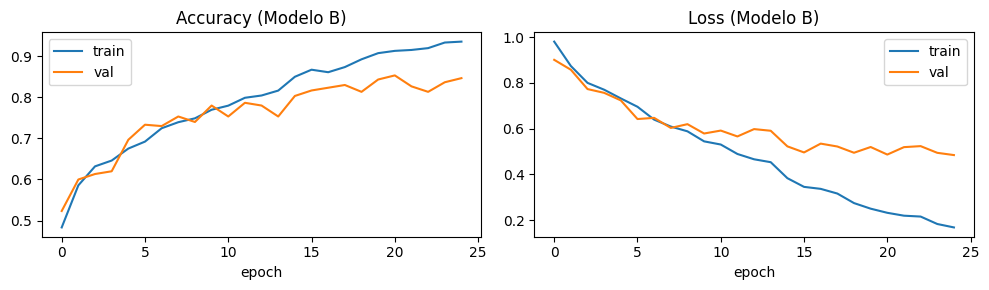

In [ ]:
# Curvas — Modelo B
csv_b = Path(PATHS["out_csv"]) / "history_modelB_sgd.csv"

try:
    dfB = pd.DataFrame(hist_b.history) if (RUN_TRAINING and 'hist_b' in globals()) else pd.read_csv(csv_b)
except FileNotFoundError:
    print("No encuentro el history de B:", csv_b, "\nEjecuta RUN_TRAINING=True una vez para generarlo.")
else:
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(dfB["accuracy"], label="train")
    ax[0].plot(dfB["val_accuracy"], label="val")
    ax[0].set_title("Accuracy (Modelo B)"); ax[0].set_xlabel("epoch"); ax[0].legend()

    ax[1].plot(dfB["loss"], label="train")
    ax[1].plot(dfB["val_loss"], label="val")
    ax[1].set_title("Loss (Modelo B)"); ax[1].set_xlabel("epoch"); ax[1].legend()

    plt.tight_layout(); plt.show()

## 8.Modelo C — Optimizador: RMSprop

*Usamos **RMSprop** (LR adaptativa por parámetro según la varianza del gradiente). Mantenemos todo igual para comparar en igualdad de condiciones.*

In [ ]:
# Modelo C (RMSprop)
#solo entrena si RUN_TRAINING=True

ckpt_path = Path(PATHS["out_models"]) / "cnn_modelC_rmsprop.keras"
csv_path  = Path(PATHS["out_csv"])    / "history_modelC_rmsprop.csv"
Path(PATHS["out_models"]).mkdir(parents=True, exist_ok=True)
Path(PATHS["out_csv"]).mkdir(parents=True, exist_ok=True)

if RUN_TRAINING:
    model_c = build_cnn(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)
    model_c.compile(
        optimizer=optimizers.RMSprop(learning_rate=1e-3, rho=0.9),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    callbacks = [
        EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
        ModelCheckpoint(filepath=str(ckpt_path), monitor="val_accuracy", save_best_only=True)
    ]
    hist_c = model_c.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks, verbose=1)
    pd.DataFrame(hist_c.history).to_csv(csv_path, index=False)

print("Modelo C (RMSprop) — modo entrega: no se entrena; se cargarán resultados guardados (modelo + history).")

Modelo C (RMSprop) — modo entrega: no se entrena; se cargarán resultados guardados (modelo + history).


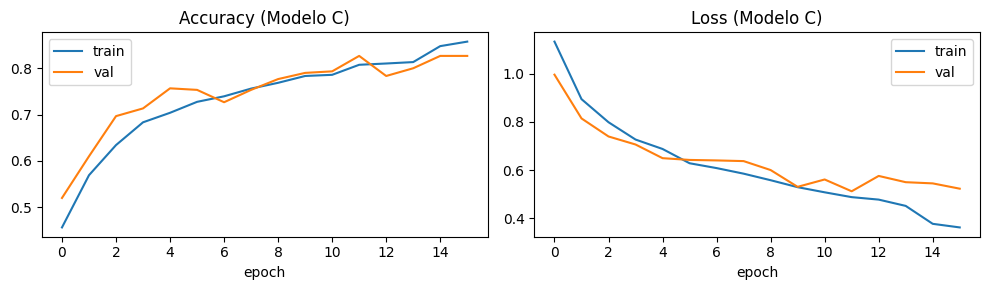

In [ ]:
# Curvas — Modelo C
csv_c = Path(PATHS["out_csv"]) / "history_modelC_rmsprop.csv"

try:
    dfC = pd.DataFrame(hist_c.history) if (RUN_TRAINING and 'hist_c' in globals()) else pd.read_csv(csv_c)
except FileNotFoundError:
    print("No encuentro el history de C:", csv_c, "\nEjecuta RUN_TRAINING=True una vez para generarlo.")
else:
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(dfC["accuracy"], label="train")
    ax[0].plot(dfC["val_accuracy"], label="val")
    ax[0].set_title("Accuracy (Modelo C)"); ax[0].set_xlabel("epoch"); ax[0].legend()

    ax[1].plot(dfC["loss"], label="train")
    ax[1].plot(dfC["val_loss"], label="val")
    ax[1].set_title("Loss (Modelo C)"); ax[1].set_xlabel("epoch"); ax[1].legend()

    plt.tight_layout(); plt.show()

## 9.Tabla comparativa de modelos

En este paso unificamos los historiales de entrenamiento de los tres modelos (Adam, SGD y RMSprop) y construimos una **tabla comparativa** con las métricas de **entrenamiento** y **validación** por el **mejor epoch** de cada uno. Seleccionamos el **mejor modelo** priorizando la **`val_accuracy`**.

**Notas de entrenamiento (comunes a los tres modelos):**
- **Early Stopping** (`monitor=val_accuracy`, `patience=4`): detenemos el entrenamiento cuando la validación deja de mejorar y **restauramos los mejores pesos**.
- **ReduceLROnPlateau** (`monitor=val_loss`, `factor=0.5`, `patience=2`, `min_lr=1e-5`): si la validación se estanca, **reducimos la learning rate** para afinar los últimos pasos.
- **Comparación justa**: misma arquitectura, mismos *batches*, mismas *epochs* máximas y **mismas callbacks**; solo cambia el **optimizador**.

In [ ]:
# 9. Tabla comparativa de entrenamiento/validación (A, B, C)
csv_dir = Path(PATHS["out_csv"])
hA = pd.read_csv(csv_dir / "history_modelA_adam.csv")
hB = pd.read_csv(csv_dir / "history_modelB_sgd.csv")
hC = pd.read_csv(csv_dir / "history_modelC_rmsprop.csv")

def resumen(hist, nombre, opt):
    idx = int(hist["val_accuracy"].values.argmax())
    return {
        "modelo": nombre,
        "optimizador": opt,
        "mejor_epoch": idx + 1,
        "val_accuracy": float(hist.loc[idx, "val_accuracy"]),
        "val_loss": float(hist.loc[idx, "val_loss"]),
        "train_accuracy": float(hist.loc[idx, "accuracy"]),
        "train_loss": float(hist.loc[idx, "loss"]),
    }

rows = [
    resumen(hA, "Modelo A", "Adam"),
    resumen(hB, "Modelo B", "SGD (momentum)"),
    resumen(hC, "Modelo C", "RMSprop"),
]
df_comp = pd.DataFrame(rows).sort_values("val_accuracy", ascending=False).reset_index(drop=True)
df_comp.to_csv(csv_dir / "comparativa_modelos.csv", index=False)

print(df_comp.to_string(index=False))
print("\nGuardado:", csv_dir / "comparativa_modelos.csv")

  modelo    optimizador  mejor_epoch  val_accuracy  val_loss  train_accuracy  train_loss
Modelo B SGD (momentum)           21      0.853333  0.486757        0.913056    0.232085
Modelo A           Adam           18      0.826667  0.478706        0.864167    0.327155
Modelo C        RMSprop           12      0.826667  0.512191        0.807500    0.487931

Guardado: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/outputs/csv/comparativa_modelos.csv


### Conclusion comparativa

El **mejor modelo** es **SGD (momentum)** con `val_accuracy = 0.8533` (epoch 21).  
**Adam** y **RMSprop** quedan en `0.8267`; entre ellos, **Adam** obtiene menor `val_loss` (0.4787), pero priorizamos `val_accuracy` para la selección.  
El uso de **EarlyStopping** y **ReduceLROnPlateau** ha permitido a **SGD** mejorar con más épocas sin sobreentrenar en exceso. Elegimos **Modelo B** para la evaluación en **test**.

## 10.Evaluación en test y matriz de confusión

Evaluamos el **mejor modelo** (SGD con momentum) sobre el **conjunto de test** y mostramos la **matriz de confusión** (normalizada por clase y con los conteos).

Test — loss: 0.5297 | acc: 0.7933


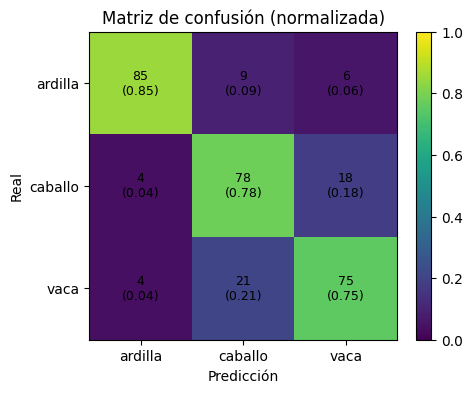

Guardado CSV: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/outputs/csv/confusion_matrix_test.csv
Guardado figura: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/outputs/figures/confusion_matrix_test.png


In [ ]:
# 10. Evaluación en test y matriz de confusión
import json, numpy as np,


out_csv = Path(PATHS["out_csv"]); out_csv.mkdir(parents=True, exist_ok=True)
out_fig = Path(PATHS["out_figs"]); out_fig.mkdir(parents=True, exist_ok=True)

metrics_path = out_csv / "metrics_test.json"
cm_csv_path  = out_csv / "confusion_matrix_test.csv"
fig_path     = out_fig / "confusion_matrix_test.png"

def plot_cm_from_array(cm):
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(cm_norm, vmin=0, vmax=1)
    ax.set_xticks(range(len(CLASS_NAMES))); ax.set_yticks(range(len(CLASS_NAMES)))
    ax.set_xticklabels(CLASS_NAMES); ax.set_yticklabels(CLASS_NAMES)
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    ax.set_title("Matriz de confusión (normalizada)")
    for i in range(len(CLASS_NAMES)):
        for j in range(len(CLASS_NAMES)):
            ax.text(j, i, f"{cm[i,j]}\n({cm_norm[i,j]:.2f})",
                    ha="center", va="center", fontsize=9)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.savefig(fig_path, dpi=130, bbox_inches="tight")
    plt.show()

if (not RECALC_TEST) and metrics_path.exists() and cm_csv_path.exists():
    # --- CARGA: métrica + CM desde disco ---
    m = json.loads(metrics_path.read_text())
    print(f"Test — loss: {m['test_loss']:.4f} | acc: {m['test_acc']:.4f}")
    cm = pd.read_csv(cm_csv_path, index_col=0).values
    plot_cm_from_array(cm)
    print("Figura guardada en:", fig_path)
else:
    # --- RE-EVALUACIÓN---
    best_model_path = Path(PATHS["out_models"]) / "cnn_modelB_sgd.keras"  # ajusta si cambias el ganador
    best_model = tf.keras.models.load_model(best_model_path)

    test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
    print(f"Test — loss: {test_loss:.4f} | acc: {test_acc:.4f}")

    # Predicciones completas en test
    y_true_list, y_pred_list = [], []
    for Xb, yb in test_ds:
        y_true_list.append(yb.numpy())
        probs = best_model.predict(Xb, verbose=0)
        y_pred_list.append(probs.argmax(axis=1))
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    # Matriz de confusión (conteos)
    cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
    pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES).to_csv(cm_csv_path, index=True)

    # Guardar métrica y figura
    metrics_path.write_text(json.dumps({"test_acc": float(test_acc),
                                        "test_loss": float(test_loss)}, indent=2))
    plot_cm_from_array(cm)

    print("Guardado CSV:", cm_csv_path)
    print("Guardado figura:", fig_path)

## Conclusiones

- **Rendimiento global (test):** `acc = 0.793` (`loss = 0.530`) con el **modelo seleccionado: SGD (momentum)**. En validación llegó a `val_acc = 0.853`, por lo que el rendimiento en test es coherente.
- **Matriz de confusión (recall por clase):**
  - **ardilla:** 85/100 → **0.85** (la mejor clase)
  - **caballo:** 78/100 → **0.78**
  - **vaca:** 75/100 → **0.75**
- **Errores típicos:** persiste la **confusión caballo ↔ vaca**  
  (caballos→vaca: **18**, vacas→caballo: **21**). Ardilla se separa bien (solo 9→caballo y 6→vaca).
- **Lectura rápida:** el modelo capta bien los patrones, pero caballo y vaca comparten rasgos visuales (postura/fondo). Para mejorar propondríamos:
  - algo más de **data augmentation** orientado a variación de fondo/escala,
  - probar una entrada algo mayor (p. ej. **256×256**) o una **CNN un poco más profunda**,
  - **transfer learning** (MobileNetV2/EfficientNet)

> Durante el entrenamiento usamos **EarlyStopping** y **ReduceLROnPlateau**, lo que ayudó a afinar la *learning rate* y alcanzar los mejores pesos sin sobreentrenar.


## 11.Visualización de 5 imágenes de test con su predicción

Mostramos 5 imágenes **aleatorias** del set de **test** con la **clase predicha** y su **confianza**. Coloreamos el título en **verde** si acierta y en **rojo** si falla.

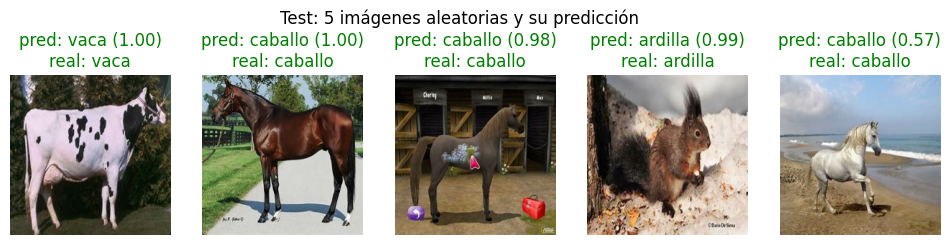

Guardado figura: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej3_clasificacion_animales/outputs/figures/muestras_test_predicciones.png


In [ ]:
# 5 imágenes aleatorias de test con predicción
if 'best_model' not in globals():
    best_model = tf.keras.models.load_model(Path(PATHS["out_models"]) / "cnn_modelB_sgd.keras")
# Reunimos todas las imágenes y etiquetas de test
Xs, ys = [], []
for Xb, yb in test_ds:
    Xs.append(Xb.numpy())
    ys.append(yb.numpy())
X_all = np.concatenate(Xs, axis=0)
y_all = np.concatenate(ys, axis=0)

# Muestreo aleatorio
rng = np.random.default_rng(42)
idx = rng.choice(len(X_all), size=5, replace=False)
X_sel = X_all[idx]
y_sel = y_all[idx]

# Predicción (el modelo ya incluye normalización)
probs = best_model.predict(X_sel, verbose=0)
pred  = probs.argmax(axis=1)
conf  = probs.max(axis=1)

# Figura
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for ax, img, yt, yp, cf in zip(axes, X_sel, y_sel, pred, conf):
    ax.imshow(img.astype("uint8"))
    ok = (yp == yt)
    ax.set_title(f"pred: {CLASS_NAMES[yp]} ({cf:.2f})\nreal: {CLASS_NAMES[int(yt)]}",
                 color=("green" if ok else "red"))
    ax.axis("off")
plt.suptitle("Test: 5 imágenes aleatorias y su predicción")
plt.show()

# Guardado
out_fig = Path(PATHS["out_figs"]); out_fig.mkdir(parents=True, exist_ok=True)
fig.savefig(out_fig / "muestras_test_predicciones.png", dpi=130, bbox_inches="tight")
print("Guardado figura:", out_fig / "muestras_test_predicciones.png")